# Лекция 06. Алгоритмы, основанные на полезностях. Алгоритм глубоких Q-сетей (DQN)

## Настройка $Q$-функции в DQN

Рассмотрим уравнения Беллмана для DQN и SARSA:
$$
Q^{\pi}_{\text{DQN}}\left(s,a\right)\approx r + \gamma\max_{a'}Q^{\pi}\left(s',a'\right);
$$
$$
Q^{\pi}_{\text{SARSA}}\left(s,a\right)\approx r +\gamma Q^{\pi}\left(s',a'\right),
$$

и
$$
Q^{\pi}_{\text{tar:DQN}}\left(s,a\right)= r + \gamma\max_{a'}Q^{\pi}\left(s',a'\right);
$$
$$
Q^{\pi}_{\text{tar:SARSA}}\left(s,a\right)= r +\gamma Q^{\pi}\left(s',a'\right).
$$

Пусть есть $\pi^1$ и $\pi^2$, а также $\hat Q^{\pi^1}(s,a)$ и $\hat Q^{\pi^2}(s,a)$. Также заданы последовательности данных $(s,a,r,s',a'_1)$ и $(s,a,r,s',a'_2)$, порожденные $\pi^1$ и $\pi^2$. В [конспекте 04](../lecture04/lecture04.ipynb) было показано, почему при текущей стратегии $\pi^1$ и более ранней стратегии с ранних этапов обучения $\pi^2$ применение $(s,a,r,s',a'_2)$ для обновления параметров $\hat Q^{\pi^1}(s,a)$ некорректно.

Оптимальная $Q$-функция определяется как выбор действия $a$ в состоянии $s$ и дальнейшее следование оптимальной стратегии $\pi^{*}$:
$$
Q^{*}(s,a)=\max_{\pi}Q^{\pi}(s,a)=Q^{\pi^{*}}(s,a).
$$

## Выбор действий в DQN

![](pictures/area.png)

## Стратегия Больцмана

$$p_{\text{softmax}}(a|s)=\dfrac{e^{Q^{\pi}(s,a)}}{\sum_\limits{a'}e^{Q^{\pi}(s,a')}}$$
$$p_{\text{B}}(a|s)=\dfrac{e^{Q^{\pi}(s,a)/\tau}}{\sum_\limits{a'}e^{Q^{\pi}(s,a')/\tau}}$$

### Пример 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def boltzmann(Q, tau):
    Q = np.array(Q)
    exp_Q = np.exp(Q / tau)
    return exp_Q / np.sum(exp_Q)

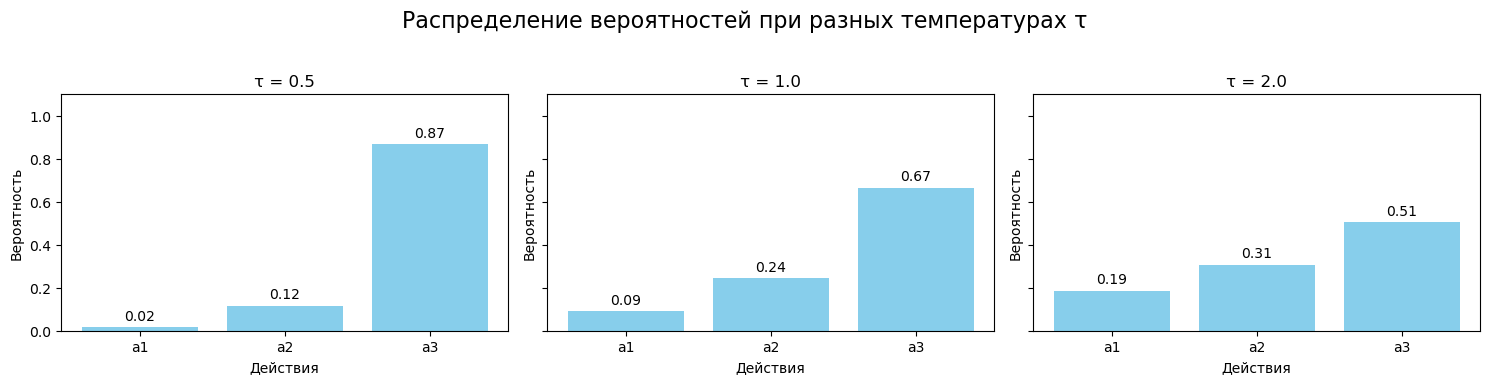

In [3]:
Q_values = np.array([1, 2, 3])
actions = ["a1", "a2", "a3"]

taus = [0.5, 1.0, 2.0]

fig, axes = plt.subplots(1, len(taus), figsize=(15, 4), sharey=True)

for ax, tau in zip(axes, taus):
    probs = boltzmann(Q_values, tau)
    bars = ax.bar(actions, probs, color="skyblue")
    ax.set_title(f'τ = {tau}')
    ax.set_ylim(0, 1.1)
    ax.set_ylabel("Вероятность")
    ax.set_xlabel("Действия")

    for bar, prob in zip(bars, probs):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02,
                f'{prob:.2f}', ha="center", va="bottom", fontsize=10)

fig.suptitle("Распределение вероятностей при разных температурах τ", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Пример 2

- softmax:
  $$x : [1;2]\rightarrow p(x) : [0.27; 0.73];$$
- распределение Больцмана
  $$\tau=5 : x : [1;2]\rightarrow p(x) : [0.45; 0.55];$$
  $$\tau=2 : x : [1;2]\rightarrow p(x) : [0.38; 0.62];$$
  $$\tau=0.5 : x : [1;2]\rightarrow p(x) : [0.12; 0.88];$$
  $$\tau=0.1 : x : [1;2]\rightarrow p(x) : [0.00; 1.00].$$

In [4]:
import numpy as np

Q_values = [
    (1.00, 9.00),
    (4.00, 6.00),
    (4.90, 5.10),
    (5.05, 4.95),
    (7.00, 3.00),
    (8.00, 2.00)
]

epsilon = 0.1
tau = 1.0

print(f"{'Q(a1)':>7} {'Q(a2)':>7} {'p_eps(a1)':>12} {'p_eps(a2)':>12} {'p_B(a1)':>10} {'p_B(a2)':>10}")
print("-" * 65)

for q1, q2 in Q_values:
    # Вычисляем p_epsilon(a1) по правилу ε-жадной стратегии
    if q1 > q2:
        p_eps_a1 = 1 - epsilon + epsilon / 2
    else:
        p_eps_a1 = epsilon / 2

    p_eps_a2 = 1 - p_eps_a1

    # Вычисляем p_B(a1), p_B(a2) через функцию
    probs = boltzmann([q1, q2], tau)
    p_b_a1, p_b_a2 = probs

    print(f"{q1:7.4f} {q2:7.4f} {p_eps_a1:12.4f} {p_eps_a2:12.4f} {p_b_a1:10.4f} {p_b_a2:10.4f}")

  Q(a1)   Q(a2)    p_eps(a1)    p_eps(a2)    p_B(a1)    p_B(a2)
-----------------------------------------------------------------
 1.0000  9.0000       0.0500       0.9500     0.0003     0.9997
 4.0000  6.0000       0.0500       0.9500     0.1192     0.8808
 4.9000  5.1000       0.0500       0.9500     0.4502     0.5498
 5.0500  4.9500       0.9500       0.0500     0.5250     0.4750
 7.0000  3.0000       0.9500       0.0500     0.9820     0.0180
 8.0000  2.0000       0.9500       0.0500     0.9975     0.0025


## Алгоритм DQN

1. Инициализация скорости обучения $\alpha$
2. Инициализация $\tau$
3. Инициализация количества прецедентов на шаг обучения, $B$
4. Инициализация количества обновлений на пакет, $U$
5. Инициализация размера пакета данных, $N$
6. Инициализация памяти предедентов с максимальным размером $K$
7. Инициализация параметров сети $\theta$ случайными значениями
8. **for** $m=1\ldots MAX\_STEPS$ **do**
9. $\quad$ Накопить и сохранить $h$ предентов $(s_i,a_i,r_i,s_i')$, используя текущую стратегию
10. $\quad$ **for** $b=1\ldots B$ **do**
11. $\quad$ $\quad$ Выбрать $b$-й пакет прецедентов из памяти 
12. $\quad$ $\quad$ **for** $u=1\ldots U$ **do**
13. $\quad$ $\quad$ $\quad$ **for** $i=1\ldots N$ **do**
14. $\quad$ $\quad$ $\quad$ $\quad$ # Рассчитать целевые $Q$-значения для каждого примера
15. $\quad$ $\quad$ $\quad$ $\quad$ $y_i=r_i+\delta_{s'_i}\gamma \max_\limits{a'_i}Q^{\pi_\theta}\left(s_i',a'_i\right),$ где $\delta_{s'_i}=0$, если $s'_i$ — конечное состояние, иначе $\delta_{s'_i}=1$
16. $\quad$ $\quad$ $\quad$ **end for**
17. $\quad$ $\quad$ $\quad$ # Рассчитать функцию потерь, например, с помощью средней квадратической ошибки
18. $\quad$ $\quad$ $\quad$ $L\left(\theta\right)=\dfrac{1}{N}\sum_i\left(y_i-Q^{\pi_{\theta}}\left(s_i,a_i\right)\right)^2$
19. $\quad$ $\quad$ $\quad$ # Обновление параметров сети
20. $\quad$ $\quad$ $\quad$ $\theta\leftarrow\theta-\alpha\nabla_{\theta}L(\theta)$
21. $\quad$ $\quad$ **end for**
22. $\quad$ **end for**
23. $\quad$ Уменьшение $\tau$
24. **end for**